# Template matching with a multiple templates

Templates are selected from Weiqiang Zhu's PhaseNet catalog.

This notebook is the continuation of the first notebook, `tm_one_template.ipynb`.

In [1]:
import os
import fast_matched_filter as fmf
import glob
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs
import pandas as pd


In [2]:
# path variables and file names
DIR_WAVEFORMS = "/data/hy4/ebeauce/Ridgecrest/2019/"
DIR_CATALOG = "../picks_phasenet/"

STATION_FILE = "adloc_stations.csv"
EVENT_FILE = "adloc_events.csv"
PICK_FILE = "adloc_picks.csv"

## Load PhaseNet catalog

Here, we read the catalog of the 2019 Ridgecrest sequence made with PhaseNet. Information is divided into three files:
- a station metadata file,
- an event metadata file (the catalog per se),
- a pick database, which contains all the P- and S-wave picks found by PhaseNet.

In [3]:
station_meta = pd.read_csv(os.path.join(DIR_CATALOG, STATION_FILE))

The following shows a very rudimentary map of the station network. Look into the `cartopy` package for more sophisticated maps.

Text(0.5, 1.0, 'Stations used to build the PhaseNet catalog')

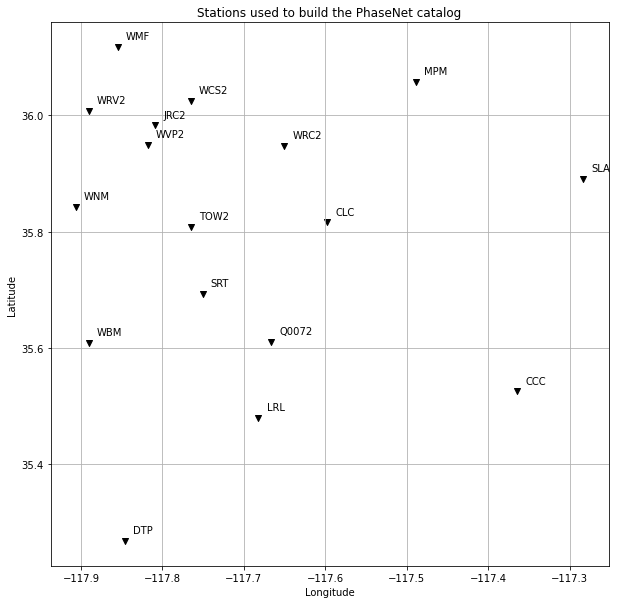

In [4]:
_station_meta = station_meta.drop_duplicates("station")

fig, ax = plt.subplots(num="station_network", figsize=(10, 10))
ax.scatter(_station_meta["longitude"], _station_meta["latitude"], marker="v", color="k")
for idx, row in _station_meta.iterrows():
    ax.text(row.longitude + 0.01, row.latitude + 0.01, row.station, va="bottom", ha="left")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid()
ax.set_title("Stations used to build the PhaseNet catalog")

In [5]:
event_meta = pd.read_csv(os.path.join(DIR_CATALOG, EVENT_FILE))

In [6]:
picks = pd.read_csv(os.path.join(DIR_CATALOG, PICK_FILE))

## Read continuous seismograms from 2019-07-04

In [7]:
def fetch_day_waveforms(date, folder="preprocessed_2_12", dir_waveforms=DIR_WAVEFORMS):
    """
    Fetches the continuous seismograms for a given day.

    Parameters
    ----------
    date : str or pandas.Timestamp
        The date for which to fetch the continuous seismograms.
    folder : str, optional
        Folder name where the preprocessed continuous seismograms are stored, by default "preprocessed_2_12".
    dir_waveforms : str, optional
        Directory where the waveform data is stored, by default DIR_WAVEFORMS.

    Returns
    -------
    obspy.Stream
        Stream object containing the fetched continuous seismograms.
    """
    date = pd.Timestamp(date)
    # full path to waveform directory for this given day
    dir_data = os.path.join(dir_waveforms, date.strftime("%Y%m%d"), folder)
    stream = obs.Stream()
    files = glob.glob(os.path.join(dir_data, "*mseed"))
    for _file in files:
        stream += obs.read(_file)
    return stream

In [8]:
# first, read the continuous seismograms into an `obspy.Stream`
date = "2019-07-04"
continuous_seismograms = fetch_day_waveforms(date)
print(continuous_seismograms.__str__(extended=True))

57 Trace(s) in Stream:
PB.B921..EHZ | 2019-07-03T23:59:59.998200Z - 2019-07-04T23:59:59.958200Z | 25.0 Hz, 2160000 samples
PB.B917..EHZ | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.JRC2..HHN | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.SRT..HHZ  | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.WCS2..HHE | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
PB.B917..EH1 | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.MPM..HHZ  | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.MPM..HHE  | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.JRC2..HHE | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
PB.B917..EH2 | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25

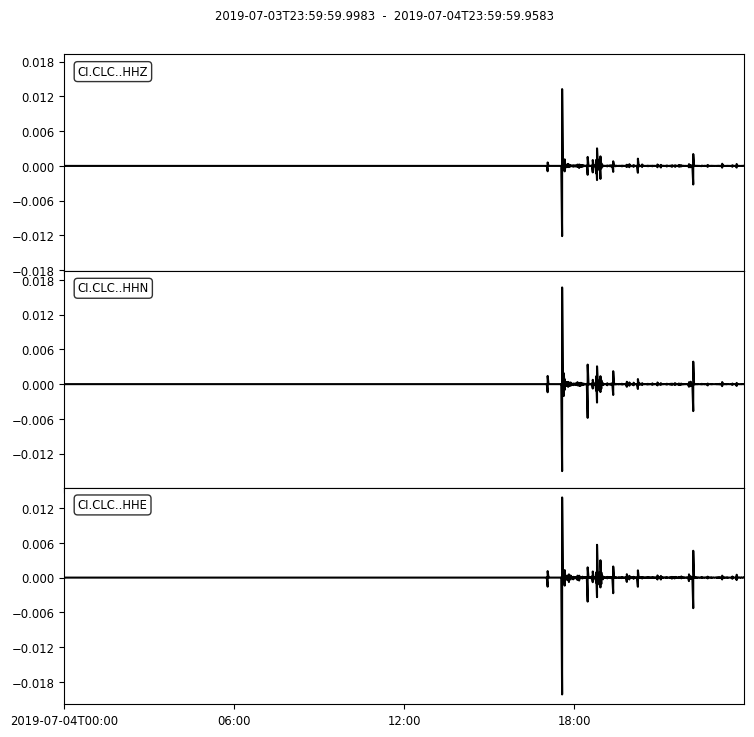

In [9]:
# plot the continuous seismograms from a single station
fig = continuous_seismograms.select(station="CLC").plot()

In [10]:
# then, cast data into `numpy.ndarray`
station_codes = list(set([st.stats.station for st in continuous_seismograms]))
component_codes = ["N", "E", "Z"]
component_aliases={"E": ["E", "2"], "N": ["N", "1"], "Z": ["Z"]}

num_stations = len(station_codes)
num_channels = len(component_codes)
num_samples = len(continuous_seismograms[0].data)

continuous_seismograms_arr = np.zeros((num_stations, num_channels, num_samples), dtype=np.float32)
for s, sta in enumerate(station_codes):
    for c, cp in enumerate(component_codes):
        for cp_alias in component_aliases[cp]:
            sel_seismogram = continuous_seismograms.select(station=sta, component=cp_alias)
            if len(sel_seismogram) > 0:
                continuous_seismograms_arr[s, c, :] = sel_seismogram[0].data
                break
            
continuous_seismograms_arr


array([[[ 4.0964762e-12,  1.3559599e-11,  1.6101020e-11, ...,
          1.8798997e-10,  5.8193428e-10,  1.5926621e-11],
        [ 8.8505540e-12,  1.4108006e-11,  2.2935031e-12, ...,
         -1.2229077e-10,  4.8499909e-11,  1.0244472e-10],
        [-1.4492193e-11, -8.8319754e-13,  5.9479423e-13, ...,
          3.6106751e-10,  1.6119951e-10, -2.9384392e-10]],

       [[-2.8151682e-11, -1.6209164e-11, -3.0759197e-11, ...,
         -1.9396069e-09, -1.6679076e-10, -2.0801223e-10],
        [-1.9637462e-11, -2.0128644e-11, -1.9461724e-11, ...,
          5.5315131e-11, -1.1718609e-09,  3.0951329e-12],
        [ 4.6178204e-11,  5.0274535e-11,  5.4542742e-11, ...,
         -7.2025702e-10,  1.2868202e-10,  4.8955934e-10]],

       [[-2.4387461e-10, -1.1533963e-10,  3.2591839e-11, ...,
          3.4707128e-09, -2.4243507e-09, -2.7698883e-09],
        [-9.4270272e-11,  3.5305114e-10,  2.7967717e-11, ...,
          3.3405665e-09,  2.7276215e-09,  3.5091063e-10],
        [ 1.3774847e-10, -2.6119817e

## Build template database 

Using the PhaseNet catalog, we will select all events with magnitudes between 3 and 5 as template events (totally arbitrary choice!).

In [11]:
def fetch_event_waveforms(
    event_picks,
    folder="preprocessed_2_12",
    dir_waveforms=DIR_WAVEFORMS,
    time_before_phase_onset_sec=2.0,
    duration_sec=10.0
    ):
    """
    Fetches the waveforms for a given event based on the picks.

    Parameters
    ----------
    event_picks : pandas.DataFrame
        DataFrame containing the picks for the event.
    folder : str, optional
        Folder name where the preprocessed waveforms are stored, by default "preprocessed_2_12".
    dir_waveforms : str, optional
        Directory where the waveform data is stored, by default DIR_WAVEFORMS.
    time_before_phase_onset_sec : float, optional
        Time in seconds to start the waveform before the phase onset, by default 2.0.
    duration_sec : float, optional
        Duration in seconds of the waveform to fetch, by default 10.0.

    Returns
    -------
    obspy.Stream
        Stream object containing the fetched waveforms.
    """
    date = pd.Timestamp(event_picks.iloc[0]["phase_time"]).strftime("%Y-%m-%d")
    # full path to waveform directory for this given day
    dir_data = os.path.join(dir_waveforms, date.replace("-", ""), folder)
    stream = obs.Stream()
    for _, pick in event_picks.iterrows():
        # check whether we have a miniseed file for this waveform
        if pick.phase_type == "P":
            files = glob.glob(os.path.join(dir_data, pick.station_id + "Z*mseed"))
        elif pick.phase_type == "S":
            files = glob.glob(os.path.join(dir_data, pick.station_id + "[N,E]*mseed"))
        starttime = obs.UTCDateTime(pick.phase_time) - time_before_phase_onset_sec
        endtime = starttime + duration_sec
        for _file in files:
            stream += obs.read(
                _file,
                starttime=starttime,
                endtime=endtime
            )
    return stream
    

In [12]:
# select events based on magnitude and origin time
selected_events_meta = event_meta[
    (event_meta["magnitude"] > 3.0)
    & (event_meta["magnitude"] < 5.0)
    & (event_meta["time"] >= "2019-07-04")
    & (event_meta["time"] < "2019-07-05")
    ]
num_templates = len(selected_events_meta)
selected_events_meta

,time,adloc_score,adloc_residual_time,num_picks,magnitude,adloc_residual_amplitude,event_index,longitude,latitude,depth_km
16,2019-07-04 17:02:55.057058245,0.770696,0.079675,90,4.476724,0.143489,1101,-117.495094,35.711607,13.586411
34,2019-07-04 17:35:01.312626662,0.789438,0.104771,70,4.829068,0.178912,1348,-117.557665,35.647086,11.567451
35,2019-07-04 17:35:52.045665172,0.659257,0.147855,58,4.382361,0.178848,4325,-117.496379,35.694142,8.195642
36,2019-07-04 17:36:58.761904132,0.874038,0.054701,13,3.358073,0.088606,20605,-117.553046,35.741222,9.369735
37,2019-07-04 17:37:14.796448320,0.757529,0.097453,46,4.123699,0.179097,9324,-117.514428,35.666419,8.910110
...,...,...,...,...,...,...,...,...,...,...
876,2019-07-04 23:12:40.040009915,0.755675,0.060584,89,3.688291,0.176078,17,-117.462513,35.673782,12.185880
877,2019-07-04 23:13:04.722581442,0.864683,0.051126,86,3.107446,0.142655,3543,-117.574288,35.751324,9.233525
928,2019-07-04 23:34:02.133079438,0.785515,0.112390,58,4.179479,0.273368,4452,-117.600550,35.602102,11.011717
947,2019-07-04 23:42:33.589915803,0.848159,0.085900,89,3.727230,0.196362,190,-117.563485,35.753536,9.027394


In general, when handling a database of template events, it is convenient to keep track of a unique template id for each template, which may be anything. However, template indexes in `numpy.ndarray` will go from 0 to `num_templates` - 1.

In [37]:
template_ids = pd.Series(selected_events_meta["event_index"].values, name="template_id")
template_ids

0      1101
1      1348
2      4325
3     20605
4      9324
      ...  
86       17
87     3543
88     4452
89      190
90      573
Name: template_id, Length: 91, dtype: int64

In [38]:
# for example, the id of the template indexed by 3 is:
template_ids.iloc[3]

20605

In [13]:
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform.
#                Here, we use windows centered around the S wave for horizontal components
#                and windows starting 1sec before the P wave for the vertical component.
PHASE_ON_COMP = {"N": "S", "E": "S", "Z": "P"}
# OFFSET_PHASE_SEC: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE_SEC["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE_SEC = {"P": 1.0, "S": 4.0}
# TEMPLATE_DURATION_SEC
TEMPLATE_DURATION_SEC = 8. 
# SAMPLING_RATE_HZ
SAMPLING_RATE_HZ = 25.
# TEMPLATE_DURATION_SAMP
TEMPLATE_DURATION_SAMP = int(TEMPLATE_DURATION_SEC * SAMPLING_RATE_HZ)


In the following cell, we build the `numpy.ndarray` of moveouts $\tilde{\tau}_{s,c}$, expressed in units of samples.

In [40]:
# first, we extract the set of relative delay times of the beginning of each
# template window on a given station and component
moveouts_samp_arr = np.zeros((num_templates, num_stations, num_channels), dtype=np.int64)
tau_min_samp_arr = np.zeros(num_templates, dtype=np.int64)
for t, tid in enumerate(template_ids):
    # add station_code columns to `selected_event_picks`
    selected_event_picks = picks[picks["event_index"] == tid].copy()
    selected_event_picks.set_index("station_id", inplace=True)
    for staid in selected_event_picks.index:
        station_code = staid.split(".")[1]
        selected_event_picks.loc[staid, "station_code"] = station_code
    tau_s_c_sec = np.zeros((num_stations, num_channels), dtype=np.float64)
    for s, sta in enumerate(station_codes):
        for c, cp in enumerate(component_codes):
            phase_type = PHASE_ON_COMP[cp]
            picks_s_c = selected_event_picks[
                (
                    (selected_event_picks["station_code"] == sta)
                    & (selected_event_picks["phase_type"] == phase_type)
                )
            ]
            if len(picks_s_c) == 0:
                # no pick for this station/component: set to -999
                tau_s_c_sec[s, c] = -999
            elif len(picks_s_c) == 1:
                # express pick relative to beginning of day (midnight)
                _pick = pd.Timestamp(picks_s_c["phase_time"].iloc[0])
                _relative_pick_sec = (_pick - pd.Timestamp(_pick.strftime("%Y-%m-%d"))).total_seconds()
                tau_s_c_sec[s, c] = _relative_pick_sec - OFFSET_PHASE_SEC[phase_type]
            else:
                # there were several picks from different channels: average them
                _relative_pick_sec = 0.
                for _pick in picks_s_c["phase_time"].values:
                    _pick = pd.Timestamp(_pick)
                    _relative_pick_sec += (_pick - pd.Timestamp(_pick.strftime("%Y-%m-%d"))).total_seconds()
                _relative_pick_sec /= float(len(picks_s_c["phase_time"]))
                tau_s_c_sec[s, c] = _relative_pick_sec - OFFSET_PHASE_SEC[phase_type]
    # now, we convert these relative times into samples 
    # and express them relative to the earliest time
    # we also store in memory the minimum time offset `tau_min_samp` for the next step
    moveouts_samp_arr[t, ...] = (tau_s_c_sec * SAMPLING_RATE_HZ).astype(np.int64)
    tau_min_samp_arr[t] = np.min(moveouts_samp_arr[t, moveouts_samp_arr[t, ...] > 0])
    moveouts_samp_arr[t, ...] = moveouts_samp_arr[t, ...] - tau_min_samp_arr[t]
moveouts_samp_arr[1, ...]

array([[-1607573, -1607573, -1607573],
       [     167,      167,      106],
       [      81,       81,       42],
       [-1607573, -1607573,      131],
       [       0,        0,        6],
       [-1607573, -1607573, -1607573],
       [      41,       41,       27],
       [-1607573, -1607573, -1607573],
       [     158,      158,       95],
       [     191,      191,      118],
       [-1607573, -1607573, -1607573],
       [      19,       19,        9],
       [-1607573, -1607573,      125],
       [      16,       16,       13],
       [     280,      280,      166],
       [      91,       91,       58],
       [     129,      129,       84],
       [-1607573, -1607573, -1607573],
       [     183,      183,      113],
       [     142,      142,       76],
       [     109,      109,       68]])

Next, we use the moveouts, in samples, to clip out the relevant template waveforms from the continuous seismograms.

In [22]:
template_waveforms_arr = np.zeros((num_templates, num_stations, num_channels, TEMPLATE_DURATION_SAMP), dtype=np.float32)
weights_arr = np.ones((num_templates, num_stations, num_channels), dtype=np.float32)

for t in range(num_templates):
    for s, sta in enumerate(station_codes):
        for c, cp in enumerate(component_codes):
            if moveouts_samp_arr[t, s, c] < 0:
                # no picks were found on this station
                weights_arr[t, s, c] = 0.
                continue
            starttime = tau_min_samp_arr[t] + moveouts_samp_arr[t, s, c]
            endtime = starttime + TEMPLATE_DURATION_SAMP
            template_waveforms_arr[t, s, c, :] = continuous_seismograms_arr[s, c, starttime:endtime]
            if template_waveforms_arr[t, s, c, :].sum() == 0.:
                # no data was available on this channel
                weights_arr[t, s, c] = 0.
            
template_waveforms_arr[0, ...]

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 2.09496045e+00,  4.62838203e-01,  6.49631083e-01, ...,
         -1.78428257e+00,  1.90448940e+00, -3.18965816e+00],
        [-3.71183324e+00,  2.64341378e+00,  1.19156015e+00, ...,
          3.04478526e+00,  3.34618545e+00, -3.37777781e+00],
        [ 3.44588165e-03,  3.95646226e-03,  6.04336802e-03, ...,
          6.44920921e+00, -3.61431193e+00, -3.68957901e+00]],

       [[ 5.26176572e-01, -8.07753578e-02, -3.75849605e-01, ...,
          1.37929571e+00, -4.45463705e+00, -3.37046409e+00],
        [ 1.92754006e+00, -1.09068453e+00, -9.91075516e-01, ...,
         -2.83115482e+00,  6.13812983e-01,  3.624

In [16]:
template_waveforms_arr.shape

(91, 21, 3, 200)

In [23]:
# normalize template waveforms for numerical reasons
norm = np.std(template_waveforms_arr, axis=-1, keepdims=True)
norm[norm == 0.] = 1. 
template_waveforms_arr /= norm

# normalize weights so that they sum up to one
weights_arr /= np.sum(weights_arr, axis=(1, 2), keepdims=True)

# normalize continuous seismograms for numerical reasons
norm = np.std(continuous_seismograms_arr, axis=-1, keepdims=True)
norm[norm == 0.] = 1. 
continuous_seismograms_arr /= norm

## Build the template matching catalog

### Run FMF

After all this data formatting, we can now run template matching (also called matched-filtering) to detect new events that are similar to our template events.

For that, use the software Fast Matched Filter (FMF): [https://github.com/beridel/fast_matched_filter](https://github.com/beridel/fast_matched_filter)

FMF offers C and CUDA-C routines to efficiently run template matching on CPUs, or even on GPUs if available to you.

In [18]:
# FMF_STEP_SAMP: this is the step between two consecutive calculation of the correlation coefficient
FMF_STEP_SAMP = 1
# ARCH: it determines whether you want to use GPUs or CPUs 
#       If you do not have an Nvidia GPU, set ARCH = "cpu"
ARCH = "gpu"

In [42]:
cc = fmf.matched_filter(
    template_waveforms_arr.astype(np.float32),
    moveouts_samp_arr.astype(np.int32),
    weights_arr.astype(np.float32),
    continuous_seismograms_arr.astype(np.float32),
    FMF_STEP_SAMP,
    arch=ARCH,
)

In [26]:
# unlike in the previous notebook, we now have multiple time series of correlation coefficients,
# one for each template
cc.shape

(91, 2159801)

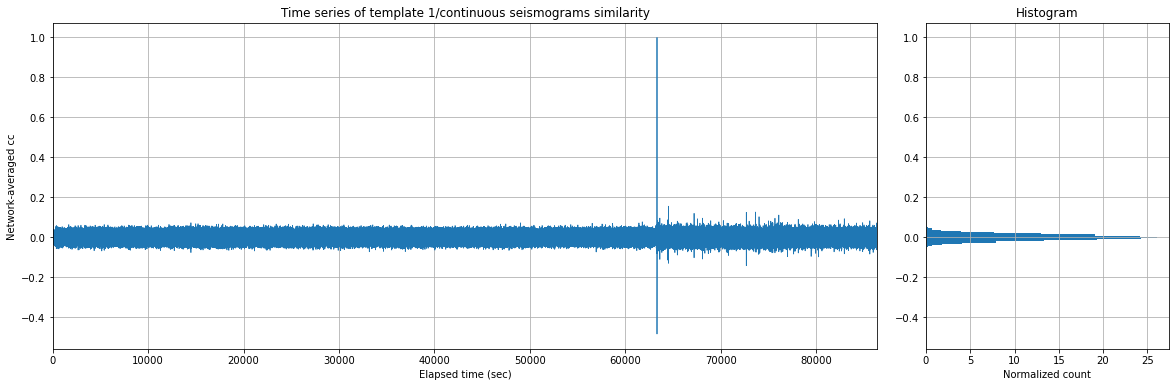

In [30]:
# let's print the output of our template matching run, which a time series of network-averaged correlation coefficients
# of same duration as the continuous seismograms
template_idx = 1
_cc = cc[template_idx, :]
time_cc = np.arange(len(_cc)) / SAMPLING_RATE_HZ

fig = plt.figure("network_averaged_cc", figsize=(20, 6))
gs = fig.add_gridspec(ncols=4)

ax1 = fig.add_subplot(gs[:3])
ax1.plot(time_cc, _cc, lw=0.75)
ax1.set_xlabel("Elapsed time (sec)")
ax1.set_ylabel("Network-averaged cc")
ax1.set_xlim(time_cc.min(), time_cc.max())
ax1.set_title(f"Time series of template {template_idx:d}/continuous seismograms similarity")

ax2 = fig.add_subplot(gs[3], sharey=ax1)
_ = ax2.hist(_cc, orientation="horizontal", bins=250, density=True)
ax2.set_xlabel("Normalized count")
ax2.set_title("Histogram")

for ax in [ax1, ax2]:
    ax.grid()


### Set detection threshold and find events

We will use the time series of correlation coefficients to build an earthquake catalog. For that, we need to set a detection threshold and define all times above that threshold as triggers caused by near-repeats of the template event.

In [31]:
def select_cc_indexes(
    cc_t,
    threshold,
    search_win,
):
    """Select the peaks in the CC time series.

    Parameters
    ------------
    cc_t: (n_corr,) numpy.ndarray
        The CC time series for one template.
    threshold: (n_corr,) numpy.ndarray or scalar
        The detection threshold.
    search_win: scalar int
        The minimum inter-event time, in units of correlation step.


    Returns
    --------
    cc_idx: (n_detections,) numpy.ndarray
        The list of all selected CC indexes. They give the timings of the
        detected events.
    """

    cc_detections = cc_t > threshold
    cc_idx = np.where(cc_detections)[0]

    cc_idx = list(cc_idx)
    n_rm = 0
    for i in range(1, len(cc_idx)):
        if (cc_idx[i - n_rm] - cc_idx[i - n_rm - 1]) < search_win:
            if cc_t[cc_idx[i - n_rm]] > cc_t[cc_idx[i - n_rm - 1]]:
                # keep (i-n_rm)-th detection
                cc_idx.remove(cc_idx[i - n_rm - 1])
            else:
                # keep (i-n_rm-1)-th detection
                cc_idx.remove(cc_idx[i - n_rm])
            n_rm += 1
    cc_idx = np.asarray(cc_idx)
    return cc_idx
    

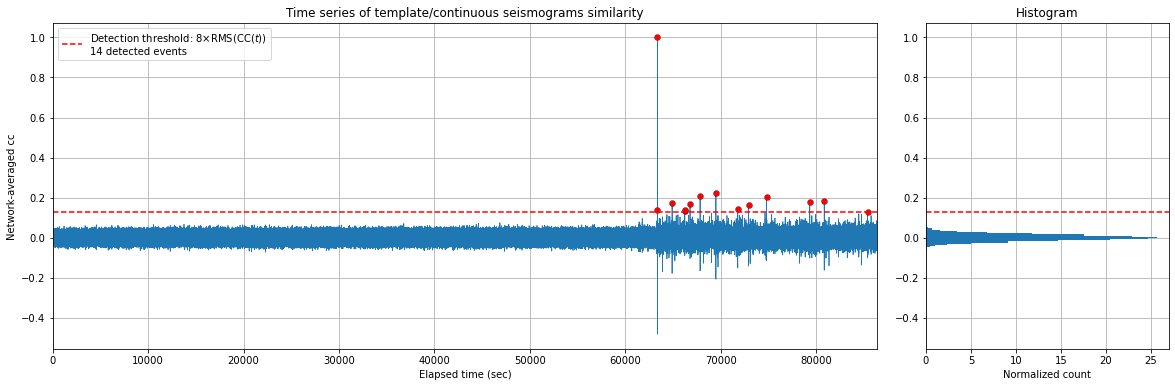

In [32]:
# INTEREVENT_TIME_RESOLUTION_SEC: In some cases, a template might trigger multiple, closely spaced detections because
#                                 of a phenomenon similar to that of "cycle skipping", where the waveform correlates
#                                 well with a time-shifted version of itself. Thus, to avoid redundant detections, we
#                                 set a minimum time separation between triggers (rule of thumb: about half the template duration)
INTEREVENT_TIME_RESOLUTION_SEC = 5.
INTEREVENT_TIME_RESOLUTION_SAMP = int(INTEREVENT_TIME_RESOLUTION_SEC * SAMPLING_RATE_HZ)
template_idx = 2
_cc = cc[template_idx, :]
time_cc = np.arange(len(_cc)) * FMF_STEP_SAMP / SAMPLING_RATE_HZ
NUM_RMS = 8.
detection_threshold = NUM_RMS * np.std(_cc)
event_cc_indexes = select_cc_indexes(_cc, detection_threshold, INTEREVENT_TIME_RESOLUTION_SAMP)

fig = plt.figure("network_averaged_cc", figsize=(20, 6))
gs = fig.add_gridspec(ncols=4)

ax1 = fig.add_subplot(gs[:3])
ax1.plot(time_cc, _cc, lw=0.75)
ax1.scatter(time_cc[event_cc_indexes], _cc[event_cc_indexes], linewidths=0.25, edgecolor="k", color="r", zorder=2)
ax1.set_xlabel("Elapsed time (sec)")
ax1.set_ylabel("Network-averaged cc")
ax1.set_xlim(time_cc.min(), time_cc.max())
ax1.set_title("Time series of template/continuous seismograms similarity")

ax2 = fig.add_subplot(gs[3], sharey=ax1)
_ = ax2.hist(_cc, orientation="horizontal", bins=250, density=True, zorder=2)
ax2.set_xlabel("Normalized count")
ax2.set_title("Histogram")

label = f"Detection threshold: {NUM_RMS:.0f}"r"$\times \mathrm{RMS}(\mathrm{CC}(t))$"f"\n{len(event_cc_indexes):d} detected events"
for ax in [ax1, ax2]:
    ax.grid()
    ax.axhline(
        detection_threshold, ls="--", color="r",
        label=label
        )
ax1.legend(loc="upper left")

### Assemble all detections to build the template matching catalog

Use the trigger times to build the earthquake catalog and extract event waveforms on a given station/component.

In [44]:
NUM_RMS = 8.

catalog = {
    "detection_time": [],
    "cc": [],
    "normalized_cc": [],
    "tid": []
}

for t, tid in enumerate(template_ids):
    detection_threshold = NUM_RMS * np.std(cc[t, :])
    event_cc_indexes = select_cc_indexes(cc[t, :], detection_threshold, INTEREVENT_TIME_RESOLUTION_SAMP)
    for i in range(len(event_cc_indexes)):
        # --------------------------------------
        catalog["detection_time"].append(pd.Timestamp(date) + pd.Timedelta(event_cc_indexes[i] * FMF_STEP_SAMP / SAMPLING_RATE_HZ, "s"))
        catalog["cc"].append(cc[t, event_cc_indexes[i]])
        catalog["normalized_cc"].append(cc[t, event_cc_indexes[i]] / detection_threshold)
        catalog["tid"].append(tid)
catalog = pd.DataFrame(catalog)
catalog.sort_values("detection_time", inplace=True)
catalog

,detection_time,cc,normalized_cc,tid
0,2019-07-04 15:42:49.840,0.167660,1.426171,1101
1,2019-07-04 16:07:21.880,0.162098,1.378858,1101
2,2019-07-04 16:13:44.960,0.252016,2.143727,1101
3,2019-07-04 17:02:56.960,1.000000,8.506305,1101
4,2019-07-04 17:09:21.680,0.339568,2.888470,1101
...,...,...,...,...
1116,2019-07-04 23:55:30.280,0.211336,1.695065,677
986,2019-07-04 23:55:56.000,0.119222,1.033934,72
1077,2019-07-04 23:56:39.680,0.209909,1.773958,8
168,2019-07-04 23:57:45.440,0.173444,1.433531,1043


### Plot some waveforms

When building a catalog, it is **always** necessary to visualize some of the detected event waveforms to get a sense of the ratio of true-to-false detection rate.

In the following, we plot the waveforms of each detected event and we also compare the stack of all the waveforms to the original template waveform. Since all events share similar waveforms, the stack is similar to the template waveform. Moreover, since noise across all these waveforms sums up incoherently, stacking acts as a denoiser which may help you produce a cleaner version of the template waveform, for example on remote stations.

In [58]:
STATION_NAME = "CLC"
COMPONENT_NAME = "Z"

sta_idx = station_codes.index(STATION_NAME)
cp_idx = component_codes.index(COMPONENT_NAME)
tp_idx = 1

subcatalog = catalog[catalog["tid"] == template_ids.iloc[tp_idx]]

detected_event_waveforms = []
for i in range(len(subcatalog)):
    detection_time_samp = (
        subcatalog["detection_time"].iloc[i] - pd.Timestamp(date)
    ).total_seconds() * SAMPLING_RATE_HZ
    idx_start = int(detection_time_samp) + moveouts_samp_arr[tp_idx, sta_idx, cp_idx]
    idx_end = idx_start + TEMPLATE_DURATION_SAMP
    detected_event_waveforms.append(continuous_seismograms_arr[sta_idx, cp_idx, idx_start:idx_end])

detected_event_waveforms = np.asarray(detected_event_waveforms)
detected_event_waveforms.shape

(4, 200)

Text(0, 0.5, 'Normalized amplitude')

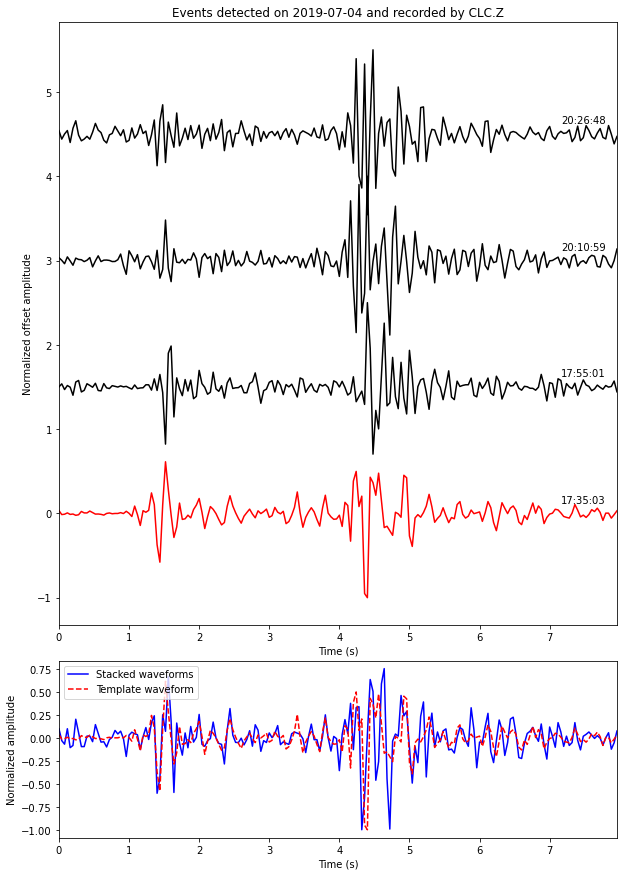

In [59]:
fig = plt.figure("detected_event_waveforms", figsize=(10, 15))
gs = fig.add_gridspec(nrows=4)

ax1 = fig.add_subplot(gs[:3])

_time_wav = np.arange(detected_event_waveforms.shape[1]) / SAMPLING_RATE_HZ

stack = np.zeros(detected_event_waveforms.shape[1])
for i in range(detected_event_waveforms.shape[0]):
    norm = np.abs(detected_event_waveforms[i, :]).max()
    if subcatalog["cc"].iloc[i] > 0.999:
        color = "r"
        template_wav = detected_event_waveforms[i, :] / norm
    else:
        color = "k"
    time_of_day = subcatalog["detection_time"].iloc[i].strftime("%H:%M:%S")
    ax1.plot(_time_wav, detected_event_waveforms[i, :] / norm + i * 1.5, color=color)
    ax1.text(0.98 * _time_wav.max(), i * 1.5 + 0.1, time_of_day, ha="right", va="bottom")
    stack += detected_event_waveforms[i, :] / norm
stack /= np.abs(stack).max()
ax1.set_xlabel("Time (s)")
ax1.set_xlim(_time_wav.min(), _time_wav.max())
ax1.set_ylabel("Normalized offset amplitude")
ax1.set_title(f"Events detected on {date} and recorded by {STATION_NAME}.{COMPONENT_NAME}")

ax2 = fig.add_subplot(gs[3], sharex=ax1)
ax2.plot(_time_wav, stack, color="blue", label="Stacked waveforms")
ax2.plot(_time_wav, template_wav, color="red", ls="--", label="Template waveform")
ax2.legend(loc="upper left")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Normalized amplitude")

## Plot inter-event time and template return time vs detection time

Having multiple templates, we can define two types of inter-event times:
- inter-event time: this is the time between two consecutive events in the catalog, disregarding their locations,
- return time: this is the time between two consecutive events detected by a same template, that is, two consecutive co-located events.

We naively assembled all the detected events from all the templates, but closely located templates can detect the same events, leading to multiple detections in the catalog. These multiples are visible with horizontal lines in the inter-event time vs detection time plot (see below).

In [60]:
catalog["interevent_time_s"] = catalog["detection_time"].diff().dt.total_seconds()
for tid in template_ids:
    subcatalog = catalog[catalog["tid"] == tid]
    catalog.loc[subcatalog.index, "return_time_s"] = subcatalog["detection_time"].diff().dt.total_seconds()
catalog

,detection_time,cc,normalized_cc,tid,interevent_time_s,return_time_s
0,2019-07-04 15:42:49.840,0.167660,1.426171,1101,NaN,NaN
1,2019-07-04 16:07:21.880,0.162098,1.378858,1101,1472.04,1472.04
2,2019-07-04 16:13:44.960,0.252016,2.143727,1101,383.08,383.08
3,2019-07-04 17:02:56.960,1.000000,8.506305,1101,2952.00,2952.00
4,2019-07-04 17:09:21.680,0.339568,2.888470,1101,384.72,384.72
...,...,...,...,...,...,...
1116,2019-07-04 23:55:30.280,0.211336,1.695065,677,51.56,777.12
986,2019-07-04 23:55:56.000,0.119222,1.033934,72,25.72,12553.08
1077,2019-07-04 23:56:39.680,0.209909,1.773958,8,43.68,7773.08
168,2019-07-04 23:57:45.440,0.173444,1.433531,1043,65.76,6180.08


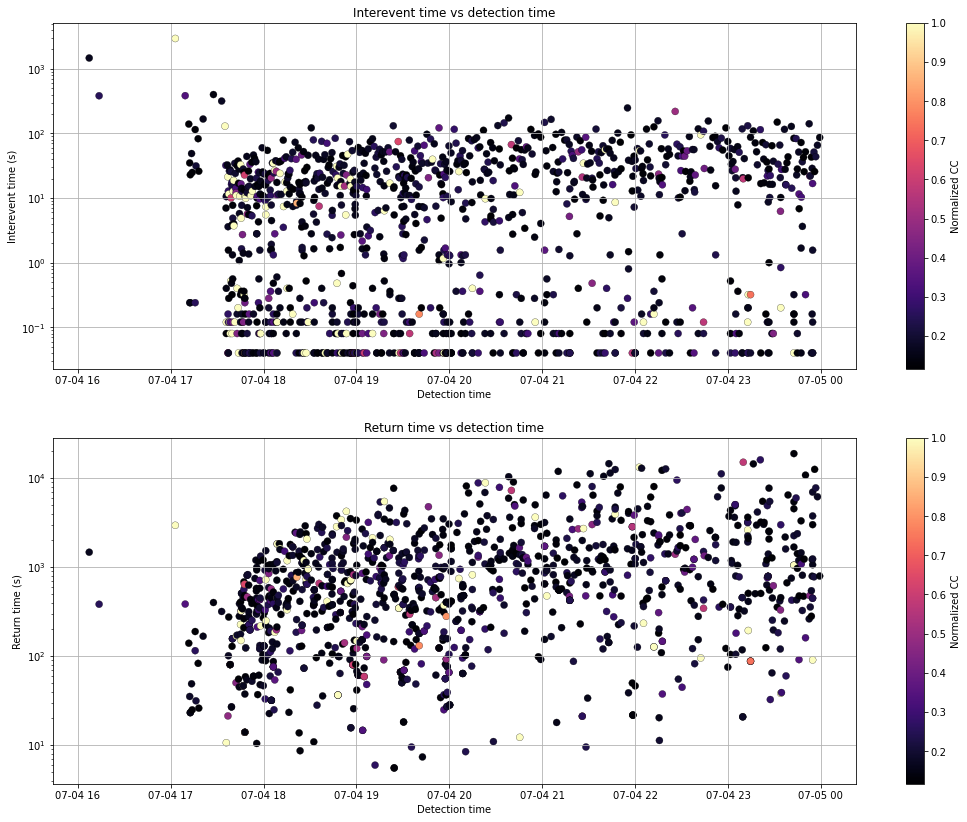

In [62]:
fig, axes = plt.subplots(num="interevent_time_vs_detection_time", nrows=2, figsize=(18, 14))

axes[0].scatter(catalog["detection_time"], catalog["interevent_time_s"], c=catalog["cc"], linewidths=0.25, edgecolor="k", cmap="magma", s=50)
axes[0].set_xlabel("Detection time")
axes[0].set_ylabel("Interevent time (s)")
axes[0].set_title("Interevent time vs detection time")

axes[1].scatter(catalog["detection_time"], catalog["return_time_s"], c=catalog["cc"], linewidths=0.25, edgecolor="k", cmap="magma", s=50)
axes[1].set_xlabel("Detection time")
axes[1].set_ylabel("Return time (s)")
axes[1].set_title("Return time vs detection time")

for ax in axes:
    ax.grid()
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label("Normalized CC")
    ax.set_yscale("log")

## "De-lumping" the catalog